<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Concat-metadata-together" data-toc-modified-id="Concat-metadata-together-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Concat metadata together</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import biom
from biom.util import biom_open
import matplotlib.pyplot as plt
from q2_matchmaker._matching import _matchmaker
import seaborn as sns
%matplotlib inline

In [2]:
table1 = biom.load_table('Averina2020/bioms/ogus_func.biom')
table2 = biom.load_table('Dan2020/bioms/ogus_func.biom')
table3 = biom.load_table('PTHS/bioms/ogus_func.biom')
table4 = biom.load_table('Wang2021/bioms/ogus_func.biom')

# remove the read number from the samples
table1_ids = dict(zip(table1.ids(), list(map(lambda x: x.split('_')[0], table1.ids()))))
table2_ids = dict(zip(table2.ids(), list(map(lambda x: x.split('_')[0], table2.ids()))))
table3_ids = dict(zip(table3.ids(), list(map(lambda x: x.split('_')[0], table3.ids()))))
table4_ids = dict(zip(table4.ids(), list(map(lambda x: x.split('_')[0], table4.ids()))))

table1.update_ids(table1_ids)
table2.update_ids(table2_ids)
table3.update_ids(table3_ids)
table4.update_ids(table4_ids)

# save the updated bioms
from biom.util import biom_open
with biom_open('Averina2020/bioms/ogus_func-corrected.biom', 'w') as f:
    table1.to_hdf5(f, 'corrected')
with biom_open('Dan2020/bioms/ogus_func-corrected.biom', 'w') as f:
    table2.to_hdf5(f, 'corrected')
with biom_open('PTHS/bioms/ogus_func-corrected.biom', 'w') as f:
    table3.to_hdf5(f, 'corrected')
with biom_open('Wang2021/bioms/ogus_func-corrected.biom', 'w') as f:
    table4.to_hdf5(f, 'corrected')    

In [3]:
# merge all of the biom tables together
#table = table1.merge(table2).merge(table3).merge(table4)
table = table1.merge(table2).merge(table4)
with biom_open('Combined/table_func.biom', 'w') as f:
    table.to_hdf5(f, 'ogus')

Correcting taxa tables

In [4]:
table1 = biom.load_table('Averina2020/bioms/ogus.biom')
table2 = biom.load_table('Dan2020/bioms/ogus.biom')
table3 = biom.load_table('PTHS/bioms/ogus.biom')
table4 = biom.load_table('Wang2021/bioms/ogus.biom')

# remove the read number from the samples
table1_ids = dict(zip(table1.ids(), list(map(lambda x: x.split('_')[0], table1.ids()))))
table2_ids = dict(zip(table2.ids(), list(map(lambda x: x.split('_')[0], table2.ids()))))
table3_ids = dict(zip(table3.ids(), list(map(lambda x: x.split('_')[0], table3.ids()))))
table4_ids = dict(zip(table4.ids(), list(map(lambda x: x.split('_')[0], table4.ids()))))

table1.update_ids(table1_ids)
table2.update_ids(table2_ids)
table3.update_ids(table3_ids)
table4.update_ids(table4_ids)

6145 x 74 <class 'biom.table.Table'> with 180222 nonzero entries (39% dense)

In [5]:
# save the updated bioms
from biom.util import biom_open
with biom_open('Averina2020/bioms/ogus-corrected.biom', 'w') as f:
    table1.to_hdf5(f, 'corrected')
with biom_open('Dan2020/bioms/ogus-corrected.biom', 'w') as f:
    table2.to_hdf5(f, 'corrected')
with biom_open('PTHS/bioms/ogus-corrected.biom', 'w') as f:
    table3.to_hdf5(f, 'corrected')
with biom_open('Wang2021/bioms/ogus-corrected.biom', 'w') as f:
    table4.to_hdf5(f, 'corrected')    

Fixing metadata

In [6]:
md1 = pd.read_table('Averina2020/sample_metadata.txt')

In [10]:
md1 = pd.read_table('Averina2020/sample_metadata.txt')
md1['Cohort'] = 'Averina2020'
md1['Age'] = md1['Age (weeks)'] / 12. # months not weeks

In [11]:
# Dan2020
md2 = pd.read_table('Dan2020/sample_metadata_JM.txt')
md2['Cohort'] = 'Dan2020'
md2['Sex'] = md2['Gender'].apply(lambda x: x.lower())
# md2['Status'] = md2['Status'].apply(lambda x: lookup[x])

In [12]:
# PTHS dataset
ebi = pd.read_table('PTHS/ebi_experiment_accessions_study_10317_prep_6771.tsv')
sra = pd.read_table('PTHS/SraRunTable.txt', sep=',')
mapping = pd.merge(sra, ebi, left_on='Experiment', right_on='experiment_accession')
mapping = mapping[['sample_name', 'experiment_accession', 'Run']]

# Read in PTHS specific data to get diagnosis
md3 = pd.read_table('PTHS/pths_study_specific_metadata.tsv', dtype=str)
md3 = md3.set_index('#SampleID')
md3 = md3.rename(columns={'age_years': 'Age', 'sex': 'Sex'})
md3 = md3.loc[md3['Age'] != 'Missing: Not provided']
md3 = md3.loc[md3['Sex'] != 'unspecified']
md3['Age'] = md3['Age'].astype(np.float64)
lookup = {'is_affected': 'ASD', 'is_not_affected': 'Control'}
md3['Status'] = md3['pths_status'].apply(lambda x: lookup[x])
pths_samples = set(md3.index[md3['pths_status'] == 'is_affected'])

# Read in AG data to get better matchins
md = pd.read_table('PTHS/sample_information_from_prep_6771.tsv')
md['Status'] = md.sample_id.apply(lambda x: 'ASD' if x in pths_samples else 'Control')
md = md.set_index('sample_id')

md = md.loc[md['age_corrected'] != 'Not applicable']
md = md.loc[md['age_corrected'] != 'Unspecified']
md = md.loc[md['sex'] != 'Not applicable']
md = md.loc[md['sex'] != 'Unspecified']
md['Age'] = md['age_corrected'].astype(np.float64)
md['Sex'] = md['sex']

md['Match_IDs'] = _matchmaker(md, 'Status', ['Age', 'Sex'], [False, True])
md3 = md.dropna(subset=['Match_IDs'])
md3['Match_IDs'] = md3['Match_IDs'].apply(lambda x: f'PTHS_{int(x)}')
# map sample names to SRA names
md3 = pd.merge(md3, mapping, right_on='sample_name', left_index=True)
md3 = md3.set_index('Run')
md3['Cohort'] = 'PTHS'

md3.to_csv('PTHS/sample_metadata.txt', sep='\t')

<ipython-input-12-ab3fd1978e98>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md3['Match_IDs'] = md3['Match_IDs'].apply(lambda x: f'PTHS_{int(x)}')


In [13]:
# Wang2020
lookup = {'TD': 'Control', 'ASD': 'ASD'}
md4 = pd.read_table('Wang2021/sample_metadata.txt', comment='#')
md4['Status'] = md4['Group'].apply(lambda x: lookup[x])
md4['Cohort'] = 'Wang2020'
#md4['Age'] = md4['Sex']
lookup = {'M': 'male', 'F': 'female'}
md4['Sex'] = md4['Sex'].apply(lambda x: lookup[x])
md4['Match_IDs'] = _matchmaker(md4, 'Status', ['Age', 'Sex'], [False, True])
md4 = md4.dropna(subset=['Match_IDs'])
md4['Match_IDs'] = md4['Match_IDs'].apply(lambda x: f'Wang2020_{int(x)}')

# Concat metadata together

In [14]:
md1 = md1.set_index('Run')
md2 = md2.set_index('Run')
md4 = md4.set_index('sampleid')

md1.index.name = 'sampleid'
md2.index.name = 'sampleid'
md3.index.name = 'sampleid'
md4.index.name = 'sampleid'

#sample_md = pd.concat((md1, md2, md3, md4), axis=0)
sample_md = pd.concat((md1, md2, md4), axis=0)

# add _1 to the end, since we forgot to before ...
#sample_md.index = list(map(lambda x : f'{x}_1', sample_md.index))

<AxesSubplot:xlabel='Cohort', ylabel='Age'>

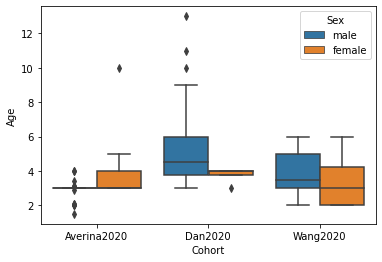

In [15]:
sns.boxplot(data=sample_md, x='Cohort', y='Age', hue='Sex')

In [16]:
# merge all of the biom tables together
#table = table1.merge(table2).merge(table3).merge(table4)
table = table1.merge(table2).merge(table4)

In [17]:
def match_f(table, metadata):
    filter_f = lambda v, i, m: i in metadata.index
    t = table.filter(filter_f, axis='sample')
    md = metadata.loc[table.ids()]
    return t, md
table, sample_md = match_f(table, sample_md)

In [18]:
filter_f = lambda v, i, m : np.sum(v>0) > 10
table = table.filter(filter_f, axis='observation')

In [19]:
from skbio.stats.composition import closure
mat = np.array(table.matrix_data.todense())
pmat = closure(mat)
logmat = np.ma.log(pmat)
data = logmat.ravel()
data = data[~data.mask]
print(data.ravel().mean(), data.ravel().std())
#sns.distplot(data)

-5.925738068259232 1.9213061513708019


In [20]:
with biom_open('Combined/ogus_table.biom', 'w') as f:
    table.to_hdf5(f, 'ogus')
sample_md.to_csv('Combined/sample_metadata.txt', sep='\t')

In [21]:
asd_df = pd.Series(table.sum(axis='observation'), index=table.ids(axis='observation'))

In [22]:
asd_df.describe()

count    4.410000e+03
mean     2.130617e+06
std      1.897200e+07
min      1.300000e+01
25%      1.720000e+02
50%      1.587000e+03
75%      3.753225e+04
max      7.238253e+08
dtype: float64

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

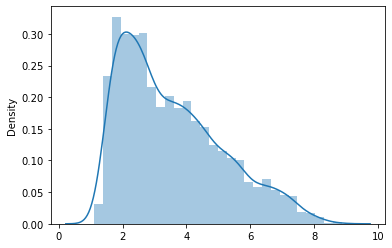

In [23]:
sns.distplot(np.log10(asd_df.values))

In [24]:
asd_df.describe()

count    4.410000e+03
mean     2.130617e+06
std      1.897200e+07
min      1.300000e+01
25%      1.720000e+02
50%      1.587000e+03
75%      3.753225e+04
max      7.238253e+08
dtype: float64

Load diabetes and IBD datasets as well

In [25]:
ibd_biom = biom.load_table('../sra_ibd_wgs/Combined/combined.biom')
dia_biom = biom.load_table('/mnt/home/jmorton/research/SPARK-autism/sfari/data/diaimmune/table.biom')

ibd_df = pd.Series(ibd_biom.sum(axis='observation'), index=ibd_biom.ids(axis='observation'))
dia_df = pd.Series(dia_biom.sum(axis='observation'), index=dia_biom.ids(axis='observation'))

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

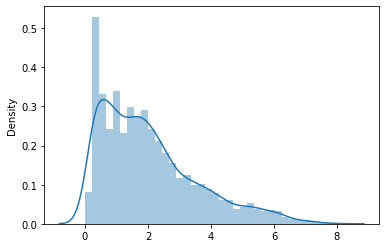

In [26]:
sns.distplot(np.log10(ibd_df.values))

In [27]:
ibd_df.describe()

count    5.795000e+03
mean     1.718553e+05
std      2.316669e+06
min      1.000000e+00
25%      6.000000e+00
50%      5.200000e+01
75%      6.355000e+02
max      1.087263e+08
dtype: float64

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

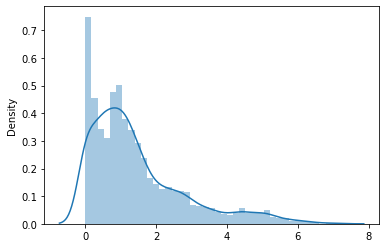

In [28]:
sns.distplot(np.log10(dia_df.values))

In [29]:
dia_df.describe()

count    5.351000e+03
mean     3.201365e+04
std      3.992089e+05
min      1.000000e+00
25%      3.000000e+00
50%      1.200000e+01
75%      1.010000e+02
max      1.348432e+07
dtype: float64

In [30]:
asd_df.index

Index(['1000562', '1000565', '1000569', '1002367', '1002804', '1003',
       '1004149', '1004326', '100480', '1005057',
       ...
       '387092', '438753', '471853', '537971', '633149', '709032', '72293',
       '754477', '76936', '92793'],
      dtype='object', length=4410)

In [31]:
## Fix IDs for diaimmune data
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxonomy, taxid, left_index=True, right_on='GOTU')
lookup = mapping[['GOTU', 'genome']].set_index('GOTU')

idx = np.array(list(map(lambda x: lookup.loc[x].values, dia_df.index))).ravel()
dia_df.index = idx

In [32]:
idx = list(set(asd_df.index) | set(dia_df.index))
df = ibd_df.reindex(index=idx).fillna(0)
df.loc[asd_df.index] += asd_df
df.loc[dia_df.index] += dia_df

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'log(total taxa counts)')

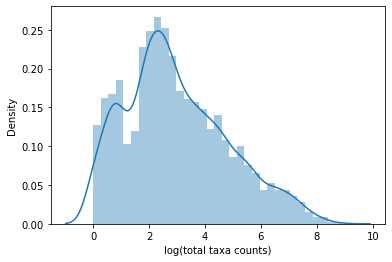

In [33]:
sns.distplot(np.log10(df.values))
plt.xlabel('log(total taxa counts)')

In [34]:
df.describe()

count    5.708000e+03
mean     1.850352e+06
std      1.929610e+07
min      1.000000e+00
25%      5.100000e+01
50%      4.905000e+02
75%      1.476425e+04
max      8.460359e+08
dtype: float64

In [35]:
df.to_csv('Combined/feature_counts.csv')

In [36]:
dia_df

398511      41.0
306537      21.0
243277       8.0
160490     447.0
242231      41.0
           ...  
484498       1.0
477680       1.0
1926284      5.0
1926277     17.0
1255658     20.0
Length: 5351, dtype: float64

Let's fix the ids for the diaimmune data

In [37]:
l2 = lookup.reset_index().set_index('genome')
l2 = l2[~l2.index.duplicated(keep='first')]
l2 = l2.reset_index().set_index('GOTU')
l2 = l2[~l2.index.duplicated(keep='first')]
l2 = l2.loc[set(dia_biom.ids(axis='observation')) & set(list(l2.index))]

l2 = l2.reset_index().set_index('GOTU')

dia_biom.filter(l2.index, axis='observation')
dia_biom.update_ids(l2['genome'].to_dict(), axis='observation', strict=False)

with biom_open('/mnt/home/jmorton/research/SPARK-autism/sfari/data/diaimmune/table-corrected.biom', 'w') as f:
    dia_biom.to_hdf5(f, 'WGS')

In [38]:
!ls /mnt/home/jmorton/research/SPARK-autism/sfari/data/diaimmune

106363_free.biom	   cleanup.sh
106364_per-gene.biom	   diff_abs.sh
106365_none.biom	   formatted
11882			   intermediate
12496			   sample_information_from_prep_8810.tsv
12496_20190524-184432.txt  sample_metadata.txt
73074_otu_table.biom	   table.biom
74945_otu_table.biom	   table-corrected.biom
age_sex_matched_posterior


In [39]:
lookup

,genome
GOTU,
G000005825,398511
G000006175,456320
G000006605,306537
G000006725,160492
G000006745,243277
...,...
G900156675,484498
G900156765,477680
G900156885,1926284


In [40]:
len(set(lookup.index))

10575

In [41]:
dia_biom.update_ids?